In [1]:
import json
import glow
glow.register(spark)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.functions import *
#from pyspark.sql.functions import array_min, col, monotonically_increasing_id, when, log10
from pyspark.sql.types import StringType
from pyspark.ml.linalg import Vector, Vectors, SparseVector, DenseMatrix
from pyspark.ml.stat import Summarizer
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.util import MLUtils

from dataclasses import dataclass


In [11]:
def plot_layout(plot_title, plot_style, xlabel):
  plt.style.use(plot_style) #e.g. ggplot, seaborn-colorblind, print(plt.style.available)
  plt.title(plot_title)
  plt.xlabel(r'${0}$'.format(xlabel))
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)
  plt.gca().yaxis.set_ticks_position('left')
  plt.gca().xaxis.set_ticks_position('bottom')
  plt.tight_layout()
  
def plot_histogram(df, col, xlabel, xmin, xmax, nbins, plot_title, plot_style, color, vline, out_path):
  plt.close()
  plt.figure()
  bins = np.linspace(xmin, xmax, nbins)
  df = df.toPandas()
  plt.hist(df[col], bins, alpha=1, color=color)
  if vline:
    plt.axvline(x=vline, linestyle='dashed', linewidth=2.0, color='black')
  plot_layout(plot_title, plot_style, xlabel)
  plt.savefig(out_path)
  plt.show()
  
def calculate_pval_bonferroni_cutoff(df, cutoff=0.05):
  bonferroni_p =  cutoff / df.count()
  return bonferroni_p

def get_sample_info(vcf_df, sample_metadata_df):
  """
  get sample IDs from VCF dataframe, index them, then join to sample metadata dataframe
  """
  sample_id_list = vcf_df.limit(1).select("genotypes.sampleId").collect()[0].__getitem__("sampleId")
  sample_id_indexed = spark.createDataFrame(sample_id_list, StringType()). \
                            coalesce(1). \
                            withColumnRenamed("value", "Sample"). \
                            withColumn("index", monotonically_increasing_id())
  sample_id_annotated = sample_id_indexed.join(sample_metadata_df, "Sample")
  return sample_id_annotated

In [12]:
#study4_bgen_path = "gs://confluence_test/study/Study4_GWAS.bgen"
#study4_df = spark.read.format("bgen").load(study4_bgen_path)

In [13]:
study4_vcf_path = "gs://confluence_test/study/Study4_GWAS.vcf"
study4_df = spark.read.format("vcf").load(study4_vcf_path)

In [14]:
study4_df.show(3)

+----------+--------+--------+--------------------+---------------+----------------+----+-------+---------------------+--------------------+
|contigName|   start|     end|               names|referenceAllele|alternateAlleles|qual|filters|splitFromMultiAllelic|           genotypes|
+----------+--------+--------+--------------------+---------------+----------------+----+-------+---------------------+--------------------+
|         5|49405662|49405663|[5:49405663:G:A,---]|              G|             [A]|null|     []|                false|[[1, [0.73, 0.255...|
|         5|49405755|49405756|[rs62390078:49405...|              C|             [A]|null|     []|                false|[[1, [0.85, 0.15,...|
|         5|49405755|49405756|[rs62390078:49405...|              C|             [T]|null|     []|                false|[[1, [0.209, 0.60...|
+----------+--------+--------+--------------------+---------------+----------------+----+-------+---------------------+--------------------+
only showing 

In [15]:
study4gwas_variant_stats = study4_df. \
                     selectExpr("*", "expand_struct(call_summary_stats(genotypes))", \
                                "expand_struct(hardy_weinberg(genotypes))")

study4gwas_variant_stats.show(3)

+----------+--------+--------+--------------------+---------------+----------------+----+-------+---------------------+--------------------+-------------------+-------+---------+----+-----------+-------+--------------+------------+--------------------+--------------------+--------------------+
|contigName|   start|     end|               names|referenceAllele|alternateAlleles|qual|filters|splitFromMultiAllelic|           genotypes|           callRate|nCalled|nUncalled|nHet|nHomozygous|nNonRef|nAllelesCalled|alleleCounts|   alleleFrequencies|          hetFreqHwe|           pValueHwe|
+----------+--------+--------+--------------------+---------------+----------------+----+-------+---------------------+--------------------+-------------------+-------+---------+----+-----------+-------+--------------+------------+--------------------+--------------------+--------------------+
|         5|49405662|49405663|[5:49405663:G:A,---]|              G|             [A]|null|     []|                fa

In [16]:
allele_freq_cutoff = 0.01
hwe = study4gwas_variant_stats. \
                 where((col("alleleFrequencies").getItem(0) >= allele_freq_cutoff) & 
                       (col("alleleFrequencies").getItem(0) <= (1.0 - allele_freq_cutoff))). \
                 withColumn("log10pValueHwe", when(col("pValueHwe") == 0, 26).otherwise(-log10(col("pValueHwe"))))

In [17]:
hwe_cutoff = calculate_pval_bonferroni_cutoff(hwe)
hwe_cutoff

2.4248302618816686e-05

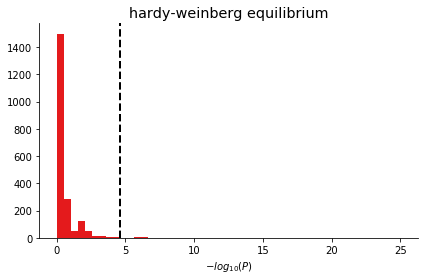

In [18]:
plot_histogram(df=hwe.select("log10pValueHwe"), 
                       col="log10pValueHwe",
                       xlabel='-log_{10}(P)',
                       xmin=0, 
                       xmax=25, 
                       nbins=50, 
                       plot_title="hardy-weinberg equilibrium", 
                       plot_style="ggplot",
                       color='#e41a1c',
                       vline = -np.log10(hwe_cutoff),
                       out_path = "/mnt/hwe.png"
                      )

In [19]:
study4gwas_variant_stats.count()

6082

In [20]:
allele_freq_cutoff = 0.005

study4gwas_variant_stats.where((col("alleleFrequencies").getItem(0) >= allele_freq_cutoff) & 
         (col("alleleFrequencies").getItem(0) <= (1.0 - allele_freq_cutoff)) &
         (col("pValueHwe") >= hwe_cutoff)).count()

2138

In [21]:
from pyspark.ml.linalg import DenseMatrix
import pyspark.sql.functions as fx
import numpy as np
import pandas as pd

In [22]:
phenotypes = pd.read_csv("gs://confluence_test/study/Study4_GWAS.samples.tab", sep=" ")

In [23]:
n_samples = study4_df.select(fx.size('genotypes')).first()[0]
covariates = DenseMatrix(n_samples, 1, np.ones(n_samples))

covariates_and_phenotypes = spark.createDataFrame([[covariates, phenotypes['status_binary'].to_list()]],
  ['covariates', 'status_binary'])

log_reg_df = study4_df.crossJoin(covariates_and_phenotypes).selectExpr(
  'contigName',
  'start',
  'names',
  'expand_struct(logistic_regression_gwas(genotype_states(genotypes), status_binary, covariates, \'LRT\'))')

In [24]:
log_reg_df.show(5)

+----------+--------+--------------------+--------------------+------------------+----------------------+-------------------+
|contigName|   start|               names|                beta|         oddsRatio|waldConfidenceInterval|             pValue|
+----------+--------+--------------------+--------------------+------------------+----------------------+-------------------+
|         5|49405662|[5:49405663:G:A,---]|-0.00399592286980...|0.9960121589613588|  [0.86530997868577...| 0.9556004613079334|
|         5|49405755|[rs62390078:49405...|0.001026005601401...|1.0010265273193015|  [0.86526570494476...| 0.9889914531746664|
|         5|49405755|[rs62390078:49405...|-0.02670878077987...|0.9736447163553955|  [0.89553921915160...| 0.5312149933955642|
|         5|49405757|[rs376842142:4940...|0.001026042207221...|1.0010265273193362|  [0.86526570494476...| 0.9889914531746664|
|         5|49405869|[5:49405870:G:A,---]| 0.09055778515435295|  1.09478425814996|  [0.95134789660488...|0.20589077510

In [25]:
log_reg_df.sort(asc("pValue")).show(5)

+----------+--------+--------------------+--------------------+------------------+----------------------+-------------------+
|contigName|   start|               names|                beta|         oddsRatio|waldConfidenceInterval|             pValue|
+----------+--------+--------------------+--------------------+------------------+----------------------+-------------------+
|         5|49405869|[5:49405870:G:A,---]| 0.09055778515435295|  1.09478425814996|  [0.95134789660488...|0.20589077510955234|
|         5|49405755|[rs62390078:49405...|-0.02670878077987...|0.9736447163553955|  [0.89553921915160...| 0.5312149933955642|
|         5|49406652|[rs140332947:4940...|0.002273157907089441|1.0022757434705767|  [0.95073863080443...| 0.9327400571260361|
|         5|49406653|[rs145482570:4940...|0.002273157888409735| 1.002275743470577|  [0.95073863080443...| 0.9327400571260361|
|         5|49405662|[5:49405663:G:A,---]|-0.00399592286980...|0.9960121589613588|  [0.86530997868577...| 0.9556004613